#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '400', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '400', 'val')
train_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '400', 'train')
val_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '400', 'val')
load_models_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models')
save_models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models', 'small', '400')

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels should be loaded from a separate directory. Each label corresponds to two particles. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [ ]:
%run '/home/renat_sergazinov/python-git-workspace/PhotoForceReconML/data_loader.py'

In [4]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_labels_path, str(i), 'angles_inner.npy'))
    y_val[i] = np.load(os.path.join(val_labels_path, str(i), 'angles_inner.npy'))

In [7]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGeneratorTrain(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGeneratorTrain(X_val[i], y_val[i], **params) 

#### VGG19 Models Training

Convolutional neural networks is defined and compiled in this step.

In [10]:
models_ai = dict()                         
for k in range(5):
     i = k + 2
     models_ai[i] = load_model(os.path.join(load_models_path, 'vgg19_angles_inner_'+str(i)+'.h5'))

In [11]:
for k in range(5):
    i = k + 2
    models_ai[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 28,416,066
Non-trainable params: 0
_________________________________________________

In [12]:
for k in range(5):
    i = 2 + k
    models_ai[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-7),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(save_models_path, 'vgg19_angles_inner_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs = 1000
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = models_ai[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 0.1493 - mean_absolute_error: 0.1493
Epoch 00001: val_loss improved from inf to 0.04761, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/vgg19_angles_inner_2.h5
10/10 [==============================] - 2s 211ms/step - loss: 0.1493 - mean_absolute_error: 0.1493 - val_loss: 0.0476 - val_mean_absolute_error: 0.0476
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.1413 - mean_absolute_error: 0.1413
Epoch 00002: val_loss improved from 0.04761 to 0.03323, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/vgg19_angles_inner_2.h5
10/10 [==============================] - 2s 167ms/step - loss: 0.1413 - mean_absolute_error: 0.1413 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.1360 - mean_absolute_error: 0.1360
Epoch 

10/10 [==============================] - ETA: 0s - loss: 0.1405 - mean_absolute_error: 0.1405
Epoch 00026: val_loss did not improve from 0.02944
10/10 [==============================] - 1s 113ms/step - loss: 0.1405 - mean_absolute_error: 0.1405 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 27/1000
10/10 [==============================] - ETA: 0s - loss: 0.1372 - mean_absolute_error: 0.1372
Epoch 00027: val_loss did not improve from 0.02944
10/10 [==============================] - 1s 110ms/step - loss: 0.1372 - mean_absolute_error: 0.1372 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444
Epoch 28/1000
10/10 [==============================] - ETA: 0s - loss: 0.1484 - mean_absolute_error: 0.1484
Epoch 00028: val_loss did not improve from 0.02944
10/10 [==============================] - 1s 113ms/step - loss: 0.1484 - mean_absolute_error: 0.1484 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 29/1000
10/10 [==============================] - ETA: 0s - loss: 0.1425 

Epoch 52/1000
10/10 [==============================] - ETA: 0s - loss: 0.1389 - mean_absolute_error: 0.1389
Epoch 00052: val_loss did not improve from 0.02736
10/10 [==============================] - 1s 108ms/step - loss: 0.1389 - mean_absolute_error: 0.1389 - val_loss: 0.0433 - val_mean_absolute_error: 0.0433
Epoch 53/1000
10/10 [==============================] - ETA: 0s - loss: 0.1462 - mean_absolute_error: 0.1462
Epoch 00053: val_loss did not improve from 0.02736
10/10 [==============================] - 1s 113ms/step - loss: 0.1462 - mean_absolute_error: 0.1462 - val_loss: 0.0492 - val_mean_absolute_error: 0.0492
Epoch 54/1000
10/10 [==============================] - ETA: 0s - loss: 0.1471 - mean_absolute_error: 0.1471
Epoch 00054: val_loss did not improve from 0.02736
10/10 [==============================] - 1s 108ms/step - loss: 0.1471 - mean_absolute_error: 0.1471 - val_loss: 0.0699 - val_mean_absolute_error: 0.0699
Epoch 55/1000
10/10 [==============================] - ETA: 0s -

Epoch 19/1000
10/10 [==============================] - ETA: 0s - loss: 0.1413 - mean_absolute_error: 0.1413
Epoch 00019: val_loss did not improve from 0.07155
10/10 [==============================] - 1s 108ms/step - loss: 0.1413 - mean_absolute_error: 0.1413 - val_loss: 0.0971 - val_mean_absolute_error: 0.0971
Epoch 20/1000
10/10 [==============================] - ETA: 0s - loss: 0.1394 - mean_absolute_error: 0.1394
Epoch 00020: val_loss did not improve from 0.07155
10/10 [==============================] - 1s 109ms/step - loss: 0.1394 - mean_absolute_error: 0.1394 - val_loss: 0.1149 - val_mean_absolute_error: 0.1149
Epoch 21/1000
10/10 [==============================] - ETA: 0s - loss: 0.1470 - mean_absolute_error: 0.1470
Epoch 00021: val_loss did not improve from 0.07155
10/10 [==============================] - 1s 106ms/step - loss: 0.1470 - mean_absolute_error: 0.1470 - val_loss: 0.1037 - val_mean_absolute_error: 0.1037
Epoch 22/1000
10/10 [==============================] - ETA: 0s -

Epoch 45/1000
10/10 [==============================] - ETA: 0s - loss: 0.1390 - mean_absolute_error: 0.1390
Epoch 00045: val_loss did not improve from 0.06072
10/10 [==============================] - 1s 109ms/step - loss: 0.1390 - mean_absolute_error: 0.1390 - val_loss: 0.1193 - val_mean_absolute_error: 0.1193
Epoch 46/1000
10/10 [==============================] - ETA: 0s - loss: 0.1422 - mean_absolute_error: 0.1422
Epoch 00046: val_loss did not improve from 0.06072
10/10 [==============================] - 1s 109ms/step - loss: 0.1422 - mean_absolute_error: 0.1422 - val_loss: 0.1084 - val_mean_absolute_error: 0.1084
Epoch 47/1000
10/10 [==============================] - ETA: 0s - loss: 0.1431 - mean_absolute_error: 0.1431
Epoch 00047: val_loss did not improve from 0.06072
10/10 [==============================] - 1s 107ms/step - loss: 0.1431 - mean_absolute_error: 0.1431 - val_loss: 0.1032 - val_mean_absolute_error: 0.1032
Epoch 48/1000
10/10 [==============================] - ETA: 0s -

Epoch 16/1000
10/10 [==============================] - ETA: 0s - loss: 0.1194 - mean_absolute_error: 0.1194
Epoch 00016: val_loss did not improve from 0.05069
10/10 [==============================] - 1s 107ms/step - loss: 0.1194 - mean_absolute_error: 0.1194 - val_loss: 0.0622 - val_mean_absolute_error: 0.0622
Epoch 17/1000
10/10 [==============================] - ETA: 0s - loss: 0.1126 - mean_absolute_error: 0.1126
Epoch 00017: val_loss did not improve from 0.05069
10/10 [==============================] - 1s 109ms/step - loss: 0.1126 - mean_absolute_error: 0.1126 - val_loss: 0.0688 - val_mean_absolute_error: 0.0688
Epoch 18/1000
10/10 [==============================] - ETA: 0s - loss: 0.1147 - mean_absolute_error: 0.1147
Epoch 00018: val_loss did not improve from 0.05069
10/10 [==============================] - 1s 110ms/step - loss: 0.1147 - mean_absolute_error: 0.1147 - val_loss: 0.0723 - val_mean_absolute_error: 0.0723
Epoch 19/1000
10/10 [==============================] - ETA: 0s -

10/10 [==============================] - ETA: 0s - loss: 0.1053 - mean_absolute_error: 0.1053
Epoch 00010: val_loss did not improve from 0.07549
10/10 [==============================] - 1s 107ms/step - loss: 0.1053 - mean_absolute_error: 0.1053 - val_loss: 0.0773 - val_mean_absolute_error: 0.0773
Epoch 11/1000
10/10 [==============================] - ETA: 0s - loss: 0.1038 - mean_absolute_error: 0.1038
Epoch 00011: val_loss improved from 0.07549 to 0.07133, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/vgg19_angles_inner_5.h5
10/10 [==============================] - 2s 159ms/step - loss: 0.1038 - mean_absolute_error: 0.1038 - val_loss: 0.0713 - val_mean_absolute_error: 0.0713
Epoch 12/1000
10/10 [==============================] - ETA: 0s - loss: 0.0963 - mean_absolute_error: 0.0963
Epoch 00012: val_loss did not improve from 0.07133
10/10 [==============================] - 1s 113ms/step - loss: 0.0963 - mean_absolute_error: 0.0963 - val_l

Epoch 60/1000
10/10 [==============================] - ETA: 0s - loss: 0.0970 - mean_absolute_error: 0.0970
Epoch 00060: val_loss did not improve from 0.05816
10/10 [==============================] - 1s 109ms/step - loss: 0.0970 - mean_absolute_error: 0.0970 - val_loss: 0.0748 - val_mean_absolute_error: 0.0748
Epoch 61/1000
10/10 [==============================] - ETA: 0s - loss: 0.0961 - mean_absolute_error: 0.0961
Epoch 00061: val_loss did not improve from 0.05816
10/10 [==============================] - 1s 110ms/step - loss: 0.0961 - mean_absolute_error: 0.0961 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704
Epoch 62/1000
10/10 [==============================] - ETA: 0s - loss: 0.1012 - mean_absolute_error: 0.1012
Epoch 00062: val_loss did not improve from 0.05816
10/10 [==============================] - 1s 110ms/step - loss: 0.1012 - mean_absolute_error: 0.1012 - val_loss: 0.0810 - val_mean_absolute_error: 0.0810
Epoch 63/1000
10/10 [==============================] - ETA: 0s -

Epoch 86/1000
10/10 [==============================] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.1001
Epoch 00086: val_loss did not improve from 0.05610
10/10 [==============================] - 1s 107ms/step - loss: 0.1001 - mean_absolute_error: 0.1001 - val_loss: 0.0684 - val_mean_absolute_error: 0.0684
Epoch 87/1000
10/10 [==============================] - ETA: 0s - loss: 0.0973 - mean_absolute_error: 0.0973
Epoch 00087: val_loss did not improve from 0.05610
10/10 [==============================] - 1s 110ms/step - loss: 0.0973 - mean_absolute_error: 0.0973 - val_loss: 0.0638 - val_mean_absolute_error: 0.0638
Epoch 88/1000
10/10 [==============================] - ETA: 0s - loss: 0.1004 - mean_absolute_error: 0.1004
Epoch 00088: val_loss did not improve from 0.05610
10/10 [==============================] - 1s 112ms/step - loss: 0.1004 - mean_absolute_error: 0.1004 - val_loss: 0.0746 - val_mean_absolute_error: 0.0746
Epoch 89/1000
10/10 [==============================] - ETA: 0s -

Epoch 12/1000
10/10 [==============================] - ETA: 0s - loss: 0.1071 - mean_absolute_error: 0.1071
Epoch 00012: val_loss improved from 0.10067 to 0.09673, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/vgg19_angles_inner_6.h5
10/10 [==============================] - 2s 162ms/step - loss: 0.1071 - mean_absolute_error: 0.1071 - val_loss: 0.0967 - val_mean_absolute_error: 0.0967
Epoch 13/1000
10/10 [==============================] - ETA: 0s - loss: 0.1068 - mean_absolute_error: 0.1068
Epoch 00013: val_loss did not improve from 0.09673
10/10 [==============================] - 1s 108ms/step - loss: 0.1068 - mean_absolute_error: 0.1068 - val_loss: 0.1200 - val_mean_absolute_error: 0.1200
Epoch 14/1000
10/10 [==============================] - ETA: 0s - loss: 0.1055 - mean_absolute_error: 0.1055
Epoch 00014: val_loss did not improve from 0.09673
10/10 [==============================] - 1s 110ms/step - loss: 0.1055 - mean_absolute_error: 

Epoch 38/1000
10/10 [==============================] - ETA: 0s - loss: 0.1015 - mean_absolute_error: 0.1015
Epoch 00038: val_loss did not improve from 0.08801
10/10 [==============================] - 1s 110ms/step - loss: 0.1015 - mean_absolute_error: 0.1015 - val_loss: 0.1057 - val_mean_absolute_error: 0.1057
Epoch 39/1000
10/10 [==============================] - ETA: 0s - loss: 0.0996 - mean_absolute_error: 0.0996
Epoch 00039: val_loss did not improve from 0.08801
10/10 [==============================] - 1s 109ms/step - loss: 0.0996 - mean_absolute_error: 0.0996 - val_loss: 0.1176 - val_mean_absolute_error: 0.1176
Epoch 40/1000
10/10 [==============================] - ETA: 0s - loss: 0.1012 - mean_absolute_error: 0.1012
Epoch 00040: val_loss improved from 0.08801 to 0.08693, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/vgg19_angles_inner_6.h5
10/10 [==============================] - 2s 157ms/step - loss: 0.1012 - mean_absolute_error: 

Epoch 64/1000
10/10 [==============================] - ETA: 0s - loss: 0.0979 - mean_absolute_error: 0.0979
Epoch 00064: val_loss did not improve from 0.08693
10/10 [==============================] - 1s 109ms/step - loss: 0.0979 - mean_absolute_error: 0.0979 - val_loss: 0.1216 - val_mean_absolute_error: 0.1216
Epoch 65/1000
10/10 [==============================] - ETA: 0s - loss: 0.0945 - mean_absolute_error: 0.0945
Epoch 00065: val_loss did not improve from 0.08693
10/10 [==============================] - 1s 109ms/step - loss: 0.0945 - mean_absolute_error: 0.0945 - val_loss: 0.1101 - val_mean_absolute_error: 0.1101
Epoch 66/1000
10/10 [==============================] - ETA: 0s - loss: 0.0971 - mean_absolute_error: 0.0971
Epoch 00066: val_loss did not improve from 0.08693
10/10 [==============================] - 1s 109ms/step - loss: 0.0971 - mean_absolute_error: 0.0971 - val_loss: 0.1256 - val_mean_absolute_error: 0.1256
Epoch 67/1000
10/10 [==============================] - ETA: 0s -

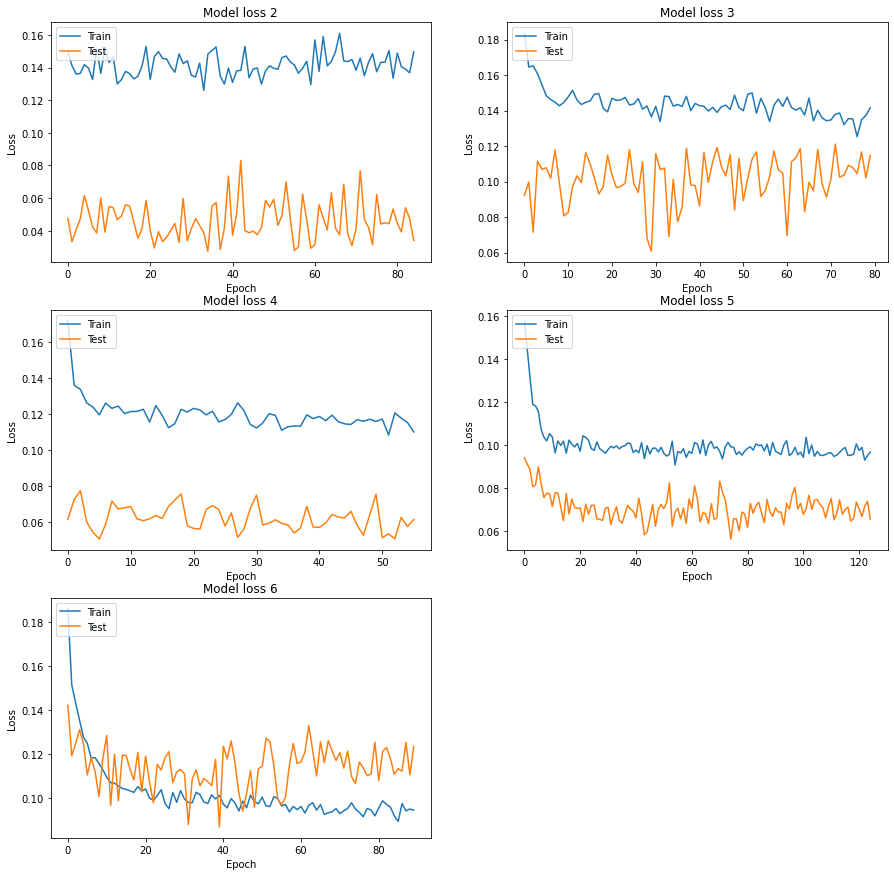

In [14]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')